<a href="https://www.kaggle.com/code/mldaniella/excercice-python-for-hpi-data?scriptVersionId=97222159" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analyzing U.S. House price index data 


* [Importing HPI data of the greatest 20 MSAs in the US ](#importingdata)

* [Visualization of HPI data](#visualizationdat) 

    - [Returns](#return)
    - [Moving Windows](#movingwindow)
    - [Volatility](#volatility) 
    - [Marginal distribution of HPI returns](#marginals)
    - [Dependence (correlation) between HPI returns](#dependence) 
    
    
* [Building mortgage portfolio making strategies](#makingportfolios)

    - [Equally weighted portfolio](#equallyweighted)
    - [Optimally weighted portfolio (Markowitz portfolio theory)](#optimalportfolios)
    

* [Compare the returns of two different investing strategies](#compareportfolios)

   - [Sharpe Ratio](#sharpe)

* [Conclusion](#conclusion)


##### In this note, we first visualize and filter out the US hous prices using various statistical tools. 
##### Then, we look into two different mortgage portfolio building strategies and compare the two strategies.

In [1]:
import os
import sys

# Data treatment
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import norm
from scipy.stats import t
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA




In [2]:
# Statistical tools
!pip install arch
from arch import arch_model

#!pip install git+git://github.com/khrapovs/skewstudent
#from skewstudent import SkewStudent

!pip install copulas

    
# Goodness of Fit test
from scipy import stats
from scipy.stats import kstest
from statsmodels.stats.diagnostic import acorr_ljungbox
from astropy.stats import kuiper

# Graph
import seaborn as sns
from itertools import permutations 

# Optimization
!pip install cvxopt
import cvxopt as opt
from cvxopt import blas, solvers

# etc
import warnings


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.9/902.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 870.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 38.0 MB/s eta 0:00:00


In [3]:
# Plot
import plotly
import cufflinks
# (*) To communicate with Plotly's server, sign in with credentials file
#import chart_studio.plotly as py  
# (*) Useful Python/Plotly tools
import plotly.tools as tls   
# (*) Graph objects to piece together plots
from plotly.graph_objs import *

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



<a id='importingdata'></a>
# Importing HPI data of the greatest 20 MSAs in the US

## Importing Data

* We import a data set that include house price indices of the 20 biggest Metropolitan Statistical Area (MSA) in the US.
   - Time span is from 1990 to 2019.

In [4]:
hpimsa=pd.read_csv("../input/hpi-20msa/Totalseries_msa_cshpi_extended_2020.csv")

* We look into the name of MSAs
* We unified the format of the name of MSAs and drop some columns that won't be used in this analysis.

In [5]:
# Look into the name of MSAs 
hpimsa.columns

# Describe the data and change the name of MSAs
hpimsa.describe()
hpimsa.rename(columns={"Unnamed: 21": "US", 'Effective date ': "date", ' AZ-Phoenix ': "Phoenix", 'CA-Los Angeles ': "Los Angeles", 'CA-San Diego ': "San Diego",'CA-San Francisco ': "San Francisco",  ' NV-Las Vegas ': "Las Vegas", 'FL-Miami ':"Miami", 'FL-Tampa ':"Tampa"  }, inplace=True)
hpimsa.drop("US", axis=1, inplace=True)
hpimsa.head()

,date,Phoenix,Los Angeles,San Diego,San Francisco,Las Vegas,Miami,Tampa,Charlotte,Cleveland,...,Seattle,Washington,Atlanta,Boston,Chicago,Dallas,Denver,Detroit,Minneapolis,Newyork
0,1990-01-01,66.56,100.23,83.77,72.87,75.46,79.20,82.26,72.69,64.78,...,58.23,92.99,NaN,72.76,68.50,NaN,47.98,NaN,63.84,80.89
1,1990-02-01,66.51,100.15,84.08,72.95,75.14,79.48,82.42,72.92,65.13,...,59.98,93.18,NaN,72.28,68.06,NaN,48.08,NaN,63.66,80.53
2,1990-03-01,66.44,100.02,84.43,73.50,76.08,79.30,83.03,72.99,65.44,...,62.29,93.02,NaN,71.19,68.68,NaN,48.29,NaN,63.98,79.99
3,1990-04-01,66.48,99.99,85.09,74.57,76.77,79.24,82.64,73.18,66.51,...,65.09,93.22,NaN,70.91,69.43,NaN,48.40,NaN,64.44,79.34
4,1990-05-01,66.44,99.79,85.53,75.12,77.59,79.33,82.76,73.50,67.07,...,66.82,93.01,NaN,70.42,69.97,NaN,48.40,NaN,64.73,79.05


* Since Dallas issued hpi data from 2000, we only use the subset of the original data dating from 2000 to 2020

In [6]:
# Inspect the first 5 rows of November-December 2006

hpimsa["date2"]=pd.to_datetime(hpimsa["date"])
new_hpimsa=hpimsa.loc[hpimsa["date2"]>=pd.Timestamp("2000-01-01")]
new_hpimsa.head()


,date,Phoenix,Los Angeles,San Diego,San Francisco,Las Vegas,Miami,Tampa,Charlotte,Cleveland,...,Washington,Atlanta,Boston,Chicago,Dallas,Denver,Detroit,Minneapolis,Newyork,date2
120,2000-01-01,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,2000-01-01
121,2000-02-01,100.43,100.62,101.07,102.70,100.33,100.21,100.51,100.43,99.63,...,100.53,100.80,100.36,100.52,101.82,100.73,100.44,100.22,100.54,2000-02-01
122,2000-03-01,101.42,102.13,103.26,106.56,100.90,100.74,100.75,100.92,100.35,...,101.70,101.18,101.31,101.53,102.04,101.99,100.65,100.58,101.27,2000-03-01
123,2000-04-01,102.13,103.70,105.42,110.97,101.20,101.83,102.02,102.27,101.42,...,103.34,102.50,103.27,102.78,103.20,103.07,101.00,102.01,102.41,2000-04-01
124,2000-05-01,102.98,104.99,107.15,115.01,101.93,102.81,103.26,102.68,102.30,...,104.91,103.38,105.85,104.38,104.11,105.26,102.09,103.74,104.35,2000-05-01


<a id='visualizationdat'></a>
# Visualization of HPI data

* <a id='return'></a>
## Return
* Frist, we calculate the monthly HPI returns for each MSA

In [7]:
# Monthly returns using method 1
monthly_r = pd.DataFrame(new_hpimsa.iloc[:,1:-1].pct_change())

# Monthly returns using method 2
monthly_r2 = np.log(new_hpimsa.iloc[1:,1:-1])-np.log(new_hpimsa.iloc[1:,1:-1].shift(1))

# Number of na in data
print(monthly_r.isna().sum())
print(monthly_r2.isna().sum())

# Replace NA values with 0
monthly_r.fillna(0, inplace=True)
monthly_r2.fillna(0, inplace=True)

# show part of monthly returns
monthly_r.head()

# put date again
new_monthly_r= pd.concat([new_hpimsa[["date2"]], monthly_r], axis=1)
new_monthly_r2= pd.concat([new_hpimsa[["date2"]], monthly_r2], axis=1)



Phoenix          1
Los Angeles      1
San Diego        1
San Francisco    1
Las Vegas        1
Miami            1
Tampa            1
Charlotte        1
Cleveland        1
Portland         1
Seattle          1
Washington       1
Atlanta          1
Boston           1
Chicago          1
Dallas           1
Denver           1
Detroit          1
Minneapolis      1
Newyork          1
dtype: int64
Phoenix          1
Los Angeles      1
San Diego        1
San Francisco    1
Las Vegas        1
Miami            1
Tampa            1
Charlotte        1
Cleveland        1
Portland         1
Seattle          1
Washington       1
Atlanta          1
Boston           1
Chicago          1
Dallas           1
Denver           1
Detroit          1
Minneapolis      1
Newyork          1
dtype: int64


In [8]:
new_monthly_r2.head()

,date2,Phoenix,Los Angeles,San Diego,San Francisco,Las Vegas,Miami,Tampa,Charlotte,Cleveland,...,Seattle,Washington,Atlanta,Boston,Chicago,Dallas,Denver,Detroit,Minneapolis,Newyork
120,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,2000-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,2000-03-01,0.009809,0.014895,0.021437,0.036896,0.005665,0.005275,0.002385,0.004867,0.007201,...,0.017364,0.011571,0.003763,0.009421,0.009998,0.002158,0.012431,0.002089,0.003586,0.007235
123,2000-04-01,0.006976,0.015256,0.020702,0.040552,0.002969,0.010762,0.012527,0.013288,0.010606,...,0.011862,0.015997,0.012962,0.019162,0.012236,0.011304,0.010534,0.003471,0.014117,0.011194
124,2000-05-01,0.008288,0.012363,0.016277,0.035759,0.007188,0.009578,0.012081,0.004001,0.008639,...,0.012678,0.015078,0.008549,0.024676,0.015447,0.008779,0.021025,0.010734,0.016817,0.018766


* Then, we change the frequency of hpi data from `monthly` to `quarterly`.

In [9]:
# set index with date2
new_monthly_r.index=new_monthly_r["date2"]
new_monthly_r2.index=new_monthly_r2["date2"]
new_monthly_r2 = new_monthly_r2.iloc[1:,:]


# Resample to quarter level (by taking average of returns)
qtr_r = new_monthly_r.resample('4M').mean()

# Print `monthly_aapl`
print(qtr_r)

# Resample to quarter level (using the last observation)
qtr_r_last = new_monthly_r.resample('4M', convention='end')

# Print `monthly_aapl`
print(qtr_r_last)



             Phoenix  Los Angeles  San Diego  San Francisco  Las Vegas  \
date2                                                                    
2000-01-31  0.000000     0.000000   0.000000       0.000000   0.000000   
2000-05-31  0.007370     0.012255   0.017424       0.035594   0.004792   
2000-09-30  0.005682     0.009278   0.014870       0.012698   0.006269   
2001-01-31  0.001398     0.004426   0.008430       0.020490   0.001722   
2001-05-31  0.006360     0.009850   0.014094       0.005561   0.007827   
...              ...          ...        ...            ...        ...   
2019-01-31  0.002302    -0.002003  -0.004716      -0.010623   0.000504   
2019-05-31  0.005132     0.005518   0.008538       0.011218   0.003816   
2019-09-30  0.007199     0.000535   0.003042      -0.002377   0.002668   
2020-01-31  0.004334     0.002327   0.000876      -0.001075   0.001450   
2020-05-31  0.006949     0.002830   0.005378       0.011773   0.004341   

               Miami     Tampa  Charl

* We make a graph for the time variations in the hpi returns.
    - the boom of housing market in the US occurred in several MSAs from 2004 to 2006.
    - the collapse in hpi return happened for all the regions in the USA almost at the same time from 2007.

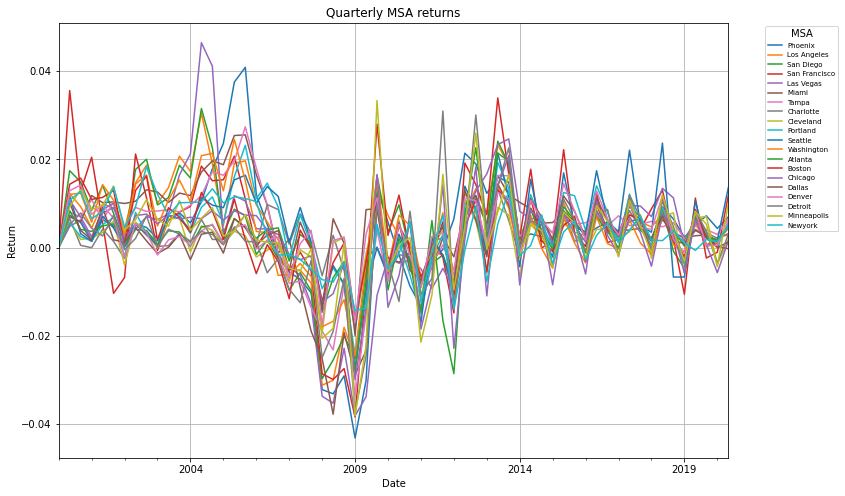

In [10]:
# Import Matplotlib's `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Plot the closing prices for `aapl`
qtr_r.plot(grid=True, figsize=(12,8))
plt.title("Quarterly MSA returns")
plt.legend(title='MSA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("Return")

# Show the plot
plt.show()

<a id='movingwindow'></a>
## Moving windows

* We calculate moving averages of HPI returns (4 months) and compare this with quarterly returns

In [11]:
# Calculate the moving average
moving_avg = new_monthly_r.rolling(window=4).mean()

# Inspect the result
moving_avg[-10:]

,Phoenix,Los Angeles,San Diego,San Francisco,Las Vegas,Miami,Tampa,Charlotte,Cleveland,Portland,Seattle,Washington,Atlanta,Boston,Chicago,Dallas,Denver,Detroit,Minneapolis,Newyork
date2,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.005132,0.005518,0.008538,0.011218,0.003816,0.002685,0.004866,0.006420,0.006693,0.007160,0.010602,0.007390,0.006924,0.008642,0.006326,0.004094,0.008180,0.008343,0.008151,-0.000646
2019-06-01,0.006852,0.005728,0.007870,0.010311,0.004510,0.002734,0.003748,0.008169,0.009366,0.008723,0.010543,0.007892,0.007393,0.012137,0.008272,0.004714,0.006916,0.011382,0.011794,-0.000261
2019-07-01,0.007563,0.003763,0.006922,0.005207,0.005667,0.002008,0.003525,0.006907,0.010289,0.008643,0.006979,0.005211,0.005724,0.008427,0.007526,0.004558,0.004490,0.011140,0.010921,0.000611
2019-08-01,0.007906,0.001439,0.005248,-0.000051,0.003746,0.002486,0.002625,0.004855,0.009300,0.005771,0.003617,0.002474,0.003645,0.004234,0.004642,0.003061,0.002064,0.006979,0.009049,0.001196
2019-09-01,0.007199,0.000535,0.003042,-0.002377,0.002668,0.002828,0.004084,0.003360,0.007040,0.003297,0.000469,0.000133,0.002484,0.002180,0.000653,0.002306,0.000541,0.003689,0.005274,0.001828
2019-10-01,0.006427,0.001345,0.000655,-0.003907,0.001076,0.003324,0.005156,0.002934,0.003354,0.000436,-0.001724,-0.000563,0.002162,-0.000299,-0.002530,0.001027,-0.000503,-0.001237,0.002286,0.002904
2019-11-01,0.005510,0.002762,-0.000197,-0.003176,0.000516,0.002967,0.005439,0.003601,0.000341,-0.001035,-0.002262,0.000076,0.002500,0.000484,-0.004923,0.000856,-0.000447,-0.003202,-0.000884,0.002629
2019-12-01,0.004768,0.002659,0.000220,-0.001757,0.001184,0.002330,0.004852,0.003117,-0.002109,-0.000630,-0.001017,0.000513,0.001689,0.000216,-0.005530,0.000196,-0.000280,-0.003574,-0.002650,0.002488
2020-01-01,0.004334,0.002327,0.000876,-0.001075,0.001450,0.001665,0.002951,0.002092,-0.003835,0.000119,0.001546,0.001196,0.001621,0.000261,-0.005680,-0.000012,0.000505,-0.003540,-0.004339,0.001360


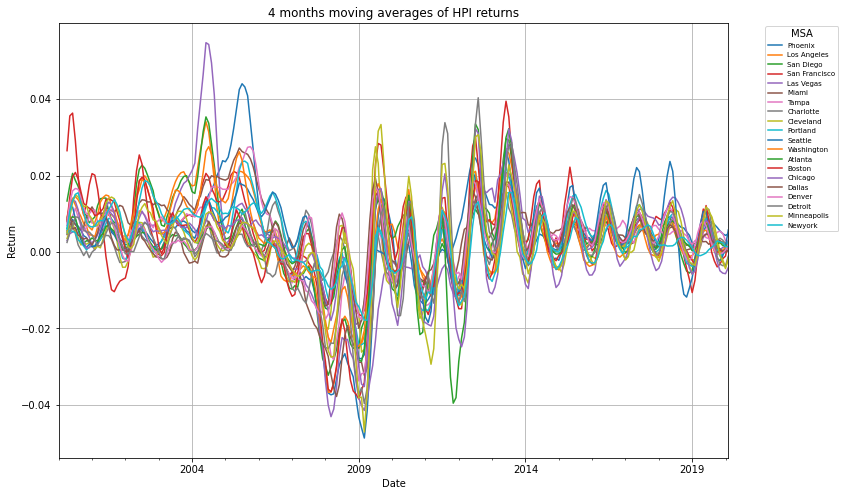

In [12]:
# Import Matplotlib's `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Plot the closing prices for `aapl`
moving_avg.plot(grid=True, figsize=(12,8))
plt.title("4 months moving averages of HPI returns")
plt.legend(title='MSA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("Return")

# Show the plot
plt.show()

* `Comment`: we found less peaky returns than the quarterly based (calculated) returns

<a id='volatility'></a>
## Volatility

* We looked into the time variations in the volatility of house price returns, and found that the volatility of house price returns increased duing the subprime mortgage crisis.

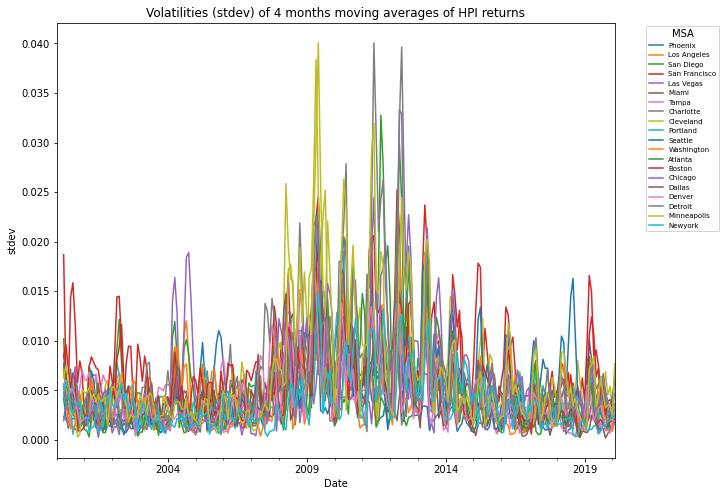

In [13]:
# Define the minumum of periods to consider 
min_periods = 4 

# Calculate the volatility
vol = new_monthly_r.rolling(window = min_periods).std() 

# Plot the volatility
vol.plot(figsize=(10, 8))

plt.title("Volatilities (stdev) of 4 months moving averages of HPI returns")
plt.legend(title='MSA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("stdev")


# Show the plot
plt.show()

<a id='marginals'></a>
## Marginal distributin of returns

* We analyze the marginal distribution of the MSA HPI returns

    -[ARMA modeling](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
    
    -[GARCH modeling](https://medium.com/@ranjithkumar.rocking/time-series-model-s-arch-and-garch-2781a982b448)


### ARMA modeling 

* Time varying mean and volatilities of the series can be modeled with ARMA-GARCH models, and this model can be applied with stationary series.
* Thus, before doing the ARMA modeling, we first do the [Dickey Fuller test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) to check the stationarity of the monthly HPI returns.
* For more details on the ARIMA model, [see this reference.](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) 

In [14]:
# Dickey–Fuller test

def DFtest(name_msa):
    
    result = adfuller(new_monthly_r[name_msa], regression='c') 
    
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    res= result[1] 
    return   res

# DF test for each series of HPI return of MSAs
set_name_msa= list(new_monthly_r.columns)[1:]
set_pvalue=[]

for name in set_name_msa:   
    res= DFtest(name)
    set_pvalue.append(res)

print(set_pvalue)



ADF Statistic: -3.336061119113707
p-value: 0.013341506929179304
Critical Values:
	1%: -3.4592326027153493
	5%: -2.8742454699025872
	10%: -2.5735414688888465
ADF Statistic: -3.1048476803188136
p-value: 0.026196512250746512
Critical Values:
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697
ADF Statistic: -2.6190560472265436
p-value: 0.0891223805270685
Critical Values:
	1%: -3.4592326027153493
	5%: -2.8742454699025872
	10%: -2.5735414688888465
ADF Statistic: -3.8057185035334906
p-value: 0.00284934613850879
Critical Values:
	1%: -3.4592326027153493
	5%: -2.8742454699025872
	10%: -2.5735414688888465
ADF Statistic: -2.5396101459509337
p-value: 0.10613172849346247
Critical Values:
	1%: -3.459105583381277
	5%: -2.8741898504150574
	10%: -2.5735117958412097
ADF Statistic: -2.7283817138857147
p-value: 0.06925443706884617
Critical Values:
	1%: -3.4593607492757554
	5%: -2.8743015807562924
	10%: -2.5735714042782396
ADF Statistic: -2.49713255732332
p-value: 0.1161735643270446

In [15]:
# pvalues od DF test
dat = pd.DataFrame(set_pvalue)

# set index
dat.set_index

# Select the MSA whose HPI returns are stationary (selected 10 MSAs)
idc = dat.loc[dat.iloc[:,0]<=0.1].index

# Extract the monthly hpi returns of those MSAs
stat_monthly_r=new_monthly_r.iloc[:,idc+1]
stat_monthly_r.head()

,Phoenix,Los Angeles,San Diego,San Francisco,Miami,Seattle,Washington,Atlanta,Denver,Minneapolis
date2,,,,,,,,,,
2000-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-02-01,0.004300,0.006200,0.010700,0.027000,0.002100,0.004800,0.005300,0.008000,0.007300,0.002200
2000-03-01,0.009858,0.015007,0.021668,0.037585,0.005289,0.017516,0.011638,0.003770,0.012509,0.003592
2000-04-01,0.007001,0.015373,0.020918,0.041385,0.010820,0.011933,0.016126,0.013046,0.010589,0.014218
2000-05-01,0.008323,0.012440,0.016411,0.036406,0.009624,0.012759,0.015193,0.008585,0.021248,0.016959


* With the stationary HPI return series, we model (or predict) the time variation of the means of hpi returns using ARMA model

    - We search for the best lags for the AR and MA terms here.

In [16]:
warnings.filterwarnings("ignore")

## Definition of the function 'ARIMA modeling'

def search_best_lags(num_ar, num_ma, msaname):
    

   
    tmp_mdl = sm.tsa.arima.ARIMA(stat_monthly_r[msaname], order=(num_ar,0,num_ma)).fit()
    tmp_aic = tmp_mdl.aic

        
    return tmp_aic, num_ar, num_ma, tmp_mdl      

                
set_name_msa= list(stat_monthly_r.columns)
list_arlag = list(range(1,14))
list_malag = list(range(1,2))       
list_arma=np.array(np.meshgrid(list_arlag,list_malag)).T.reshape(-1,2)


def calcul_arima(name): 
    
    res=list(map(lambda x,y: search_best_lags(x,y,name), list_arma[:,0],list_arma[:,1]))
    sub_res=[]
    
    for i in range(0,len(res)): 
        sub_res.append(res[i][0])

    idx=sub_res.index(min(sub_res)) # select the index for the lowest AIC value
    best_mdl= res[idx][3] 
    best_aic= best_mdl.aic
    best_order_ar=res[idx][1]
    best_order_ma=res[idx][2]
    
    return best_aic, best_order_ar, best_order_ma, best_mdl

# Application of the fuction above to all MSAs

resid_msa=stat_monthly_r.copy()
set_name_msa= list(stat_monthly_r.columns)

set_info=[]

for name in set_name_msa:   
    
    best_aic, best_order_ar, best_order_ma, best_mdl = calcul_arima(name)
    set_info.append([best_aic, best_order_ar, best_order_ma, best_mdl])
    residseries= pd.DataFrame(best_mdl.resid)
    resid_msa[name]=residseries
    




* To analyse (or predict) the time variations in the volatilities of hpi returns, we use the GARCH model.
    - We search for the best lag for the GARCH terms here.
    - We also search for the best distribution of residuals and fit the model with the best distribution.


In [17]:
warnings.filterwarnings("ignore")

# We fit the GARCH(1,1) model and using AIC, find the best distribution of residuals.

def get_best_model(num_ar, num_ma, distt, msaname):    
   
    tmp_mdl = arch_model(resid_msa[msaname], p=num_ar, o=0, q=num_ma, dist=distt).fit(update_freq=5, disp='off') # modeling
    tmp_aic = tmp_mdl.aic
    
    return tmp_aic, num_ar, num_ma, distt, tmp_mdl    


set_name_msa= list(stat_monthly_r.columns)
list_arlag = list(range(1,10))
list_malag = list(range(1,10))
##d_rng = list(['Normal', 'StudentsT', 'skewt'])
d_rng = list(['Normal', 'StudentsT'])
list_armadist = np.array(np.meshgrid(list_arlag,list_malag,d_rng)).T.reshape(-1,3)
arlag = list(map(lambda x: list_armadist[:,0].astype(int)[x].item(), range(1, len(list_armadist[:,0]))))
malag = list(map(lambda x: list_armadist[:,1].astype(int)[x].item(), range(1, len(list_armadist[:,1]))))


def calcul_garch(name): 
    
    res=list(map(lambda x,y,z: get_best_model(x,y,z, name), arlag, malag, list_armadist[:,2]))
 
    sub_res=[]
    
    for i in range(0,len(res)): 
        sub_res.append(res[i][0])

    idx=sub_res.index(min(sub_res)) # select the index for the lowest AIC value
    best_mdl= res[idx][4] 
    best_aic= best_mdl.aic
    best_order_ar=res[idx][1]
    best_order_ma=res[idx][2]
    best_dist=res[idx][3]
    
    return best_aic, best_order_ar, best_order_ma, best_dist, best_mdl



# For all the MSAs, we fit the GARCH(1,1) model and find the best distribution of residuals.

resid_msa_degarch=stat_monthly_r.copy()
distset=[]
PIT = stat_monthly_r.copy()
set_name_msa= list(stat_monthly_r.columns)

for name in set_name_msa:   
    aic, order_ar, order_ma, dist, mdl = calcul_garch(name)
    resid_msa_degarch[name] = mdl.std_resid
    distset.append(dist)
    stdzd_resid = mdl.std_resid
    
    if dist == 'Normal':
        PIT[name] = norm.cdf(stdzd_resid)
    elif dist ==  'StudentsT':
        PIT[name] = t.cdf(stdzd_resid, mdl.params[-2])
    #elif dist== 'skewt': # skewt distribution
    #    skewt = SkewStudent(eta = mdl.params[-2], lam = mdl.params[-1])
    #    PIT[name] = skewt.cdf(stdzd_resid)
               


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: 

In [18]:
print(resid_msa_degarch)


             Phoenix  Los Angeles  San Diego  San Francisco     Miami  \
date2                                                                   
2000-01-01 -1.129639    -1.042993  -0.721268      -0.478622 -1.174429   
2000-02-01  1.400070     1.318613   2.008415       3.124017  0.349071   
2000-03-01  1.414293     1.887649   1.821477       0.761500  1.201816   
2000-04-01 -1.433878    -0.065493  -0.164602       0.607844  1.570522   
2000-05-01  0.423346    -0.561953  -0.569644       0.589687  0.005092   
...              ...          ...        ...            ...       ...   
2019-10-01  1.005895     0.193860  -0.595905       0.123282  0.423798   
2019-11-01  0.156866    -0.086134   0.961100       0.732838 -1.009284   
2019-12-01  0.844572    -1.063963  -0.336132       0.349521 -0.231718   
2020-01-01 -1.445994     0.406666  -0.531994      -1.481934 -0.728002   
2020-02-01  1.362764    -0.604968   0.231549       1.137004  2.128307   

             Seattle  Washington   Atlanta    Denv

### Goodness of Fit

* We now check the `Goodness of Fit`.
  - If the data is well fitted, the distribution (cdf) of the residual (PIT) should follow the uniform distribution.
  - We do some `Goodness of Fit (GoF)` test. 
    - [`Kolmogorov-Smirnov (KS)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html): this test evaluates departures from the null hypothesis that the cumulative density function (cdf) of                                the marginal models follow a Uniform [0,1].    
    - [`Kuiper’s test (KP)`](https://docs.astropy.org/en/stable/api/astropy.stats.kuiper.html) for uniformity: This test puts more weight on the tails of the distribution.  
    - [`Ljung-Box test`](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html): for lack of autocorrelation in the squared standardized residuals of the GARCH(1,1) models at orders 1, 2, 3, 4 and 5.

In [19]:
# Plotting residuals de-GARCHed 

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 



In [20]:
# KS test

res_ks={}

for name in resid_msa_degarch.columns:
    sPIT=PIT[name]
    res_ks[name]= kstest(sPIT, "uniform").pvalue
    
res_ks

{'Phoenix': 0.5392977733193446,
 'Los Angeles': 0.5940163330904278,
 'San Diego': 0.2591576064747235,
 'San Francisco': 1.3685778265650562e-12,
 'Miami': 0.6102771793780416,
 'Seattle': 1.115954951506374e-40,
 'Washington': 0.2784097299987489,
 'Atlanta': 0.6765044740395798,
 'Denver': 1.807673743980291e-56,
 'Minneapolis': 0.15111918321836704}

In [21]:
# Kuiper’s test (KP)

res_kp={}

for name in resid_msa_degarch.columns:
    sPIT=PIT[name]
    res_kp[name]=kuiper(sPIT)[0]

res_kp

{'Phoenix': 0.07810285779284797,
 'Los Angeles': 0.08813446831513197,
 'San Diego': 0.09675177528265569,
 'San Francisco': 0.47479134630675873,
 'Miami': 0.08458001158951267,
 'Seattle': 0.852942908196429,
 'Washington': 0.09910482249292324,
 'Atlanta': 0.07448272600652706,
 'Denver': 0.9999999999999888,
 'Minneapolis': 0.08924724102761439}

In [22]:
# Ljung Box test 

ljbox_stat ={}

for name in resid_msa_degarch.columns:
    stdResid=resid_msa_degarch[name]
    ljbox_stat[name]=acorr_ljungbox(stdResid**2, lags=[1,2,3,4,5])['lb_pvalue'][1]

ljbox_stat

{'Phoenix': 0.5279972232989131,
 'Los Angeles': 0.686909249915135,
 'San Diego': 0.9561120626579743,
 'San Francisco': 0.6888370006409088,
 'Miami': 0.5731246963609604,
 'Seattle': 0.7334471152719637,
 'Washington': 0.2700836077300485,
 'Atlanta': 0.00918897017855484,
 'Denver': 0.5068134174860552,
 'Minneapolis': 0.5027352350631102}

### Summary of results (Goodness of Fitness)


* The results of the `Goodness of Fit` tests.
    - `Kolmogorov-Smirnov (KS)`: the results show that the PITs calculated using the standardized residuals from the GRACH, follow a Uniform [0,1].
    - `Kuiper’s test (KP)` results also give us the same results (we can not reject the null hypothesis that the PITs follow a Unform [0,1] at the 5% level of significance. 
    - We did `Ljung-Box test` for lack of autocorrelation in the squared standardized residuals of the GARCH(1,1) models at orders 1, 2, 3, 4 and 5. The results show that there is no autocorrelation in the squared standardized residuals of the GARCH modes at each order for all series except Atlanta**

<a id='dependence'></a>
## Dependence analysis

* [Linear correlation (Pearson's correlation)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
    - [mapping](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas)
* [Dependence with copula](https://pypi.org/project/copulas/)
    - The reason why we do the Goodness of Fit tests above is to estimate the correlation (dependence) between HPI using copula functions and the PITs

### Linear correlation

* Static correlation 

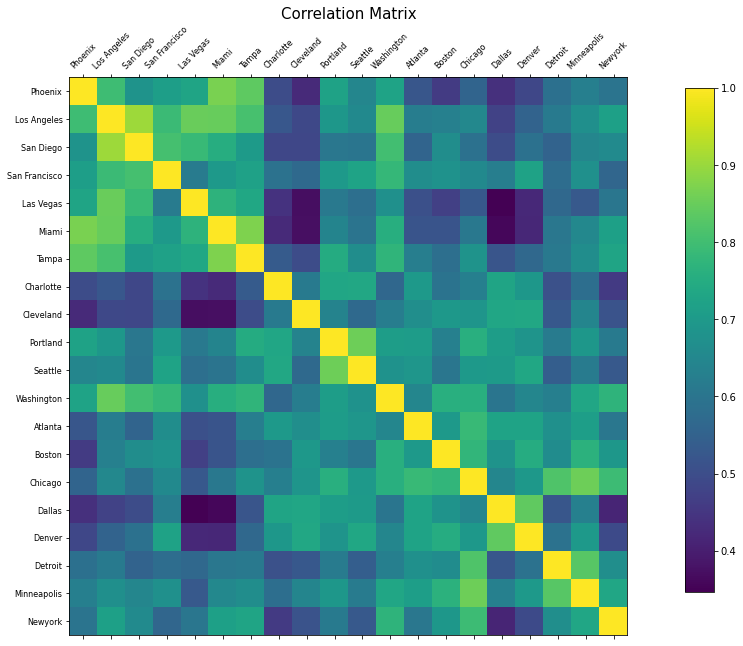

In [23]:
# Correlation (Pearson's correlation)

dfcorr= new_monthly_r.iloc[:,1:].corr()
f= plt.figure(figsize=(10, 10))

ax1=plt.matshow(dfcorr, fignum=f.number)
plt.xticks(range(dfcorr.shape[1]), dfcorr.columns, fontsize=8, rotation=45)
plt.yticks(range(dfcorr.shape[1]), dfcorr.columns, fontsize=8)
ttl=plt.title('Correlation Matrix', fontsize=15);
ttl.set_position([.5, 1.1])

cbar_ax = f.add_axes([1.005, 0.15, 0.04, 0.7])

cb = plt.colorbar(cax=cbar_ax)
cb.ax.tick_params(labelsize=10)




* `Comment`

    - We can see that the comovement of house prices in southern california area (LA, SF, SD, LV) is more distinct than the one of other regions.
    - We can also see that the HPI returns of Phoenix (AZ), Miami and Tampa (Florida) area also comove with the ones of those regions.
    - If you are thinking of putting your money in the portfolio composed of the mortgages originated in the US, you might not compose your portfolio with mortgages from southern california area only.



<a id='makingportfolios'></a>
# Building mortgage portfolio making strategies

#### We assume that we took one of those two strategy to make a portfolio from 2000.

* Equally weighted portfolios
    - We took this strategy every year

* [Efficient portfolio (mean variance analysis)](https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/)
    - We took this strategy every year


#### What are the returns of and volatilities of these two portfolios since then? 


<a id='equallyweighted'></a>

## Equally weighted Portfolio

Text(0, 0.5, 'volatility')

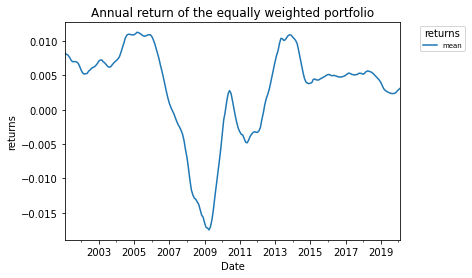

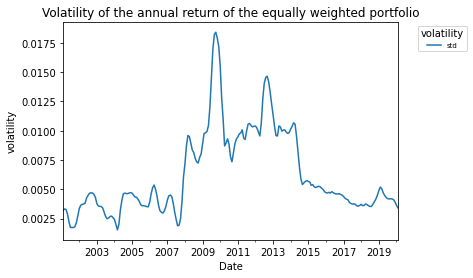

In [24]:
## Froming an equally weighted portfolio
# The variation in the return and volatility of this portfolio 

def eqw_portfolio(returns):
    
    ''' 
    Returns the mean and standard deviation of returns for an equally weighted portfolio
    
    '''

    p = np.asmatrix(np.mean(returns, axis=0))
    w = np.asmatrix([1/len(returns.columns)]*len(returns.columns))
    C = np.asmatrix(np.cov(returns.T))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma


df = new_monthly_r.iloc[:,1:]
 
set_mu=[]
set_sig=[]
set_date=[]

for i in range(len(df)-13):
    
    returns = df.iloc[1+i:1+i+12,:]
    mu, sigma = eqw_portfolio(returns)
    set_mu.append(float(mu))
    set_sig.append(float(sigma))
    set_date.append(new_monthly_r.index[1+i+12])




# Plot the mean of the equally weighted portfolio
mean_port = pd.concat([pd.DataFrame({"date":set_date}),pd.DataFrame({"mean":set_mu})],axis=1)
mean_port.date = pd.to_datetime(mean_port["date"])
mean_port.set_index("date", inplace=True)
mean_port.plot()

plt.title("Annual return of the equally weighted portfolio")
plt.legend(title='returns', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("returns")



# Plot the stdev of the annual return of the equally weighted portfolio
std_port = pd.concat([pd.DataFrame({"date":set_date}),pd.DataFrame({"std":set_sig})],axis=1)
std_port.date = pd.to_datetime(std_port["date"])
std_port.set_index("date", inplace=True)
std_port.plot()

plt.title("Volatility of the annual return of the equally weighted portfolio")
plt.legend(title='volatility', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("volatility")



<a id='optimalportfolios'></a>    
## Optimally weighted portfolio 

* For more information on the fct `solver.qp()` in `cvxopt` used here to find the optimal portfolio using Markowitz portfolio theory, see [this.](https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf)

In [25]:
## Find the efficient portfolio using Markowitz portfolio theory (Modern portfolio theory)

def optimal_portfolio(returns):
    n = len(returns.T)
    returns = np.array(returns)
    
    N = 100
    mus = [(10**(5.0 * t/N - 1.0))/100 for t in range(N)]
   
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns.T))
    pbar = opt.matrix(np.mean(returns, axis=0))
    
    # Create constraint matrices (inequality such as <0 - G,h, equality such as =0, A,b)
    G = -opt.matrix(np.eye(n))   # Negative n x n identity matrix. w_0, w_1, ... w_n>0
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))  # w_0 + w_1 + ... + w_n=1
    b = opt.matrix(1.0)
   
    # Silent cvxopt solver
    solvers.options['show_progress'] = False

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate risks and returns for frontier 
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## Calculate the 2nd degree polynomial of the frontier curve 
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0]) # coeff of x^2 / coeff of C
    
    # Calculate the optimal portfolio 
    try:
        wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    except (ArithmeticError, ValueError):
        wt = 'NA'
        pass
    
    return np.asarray(wt), returns, risks

df = new_monthly_r.iloc[:,1:]

set_w_opt=[]
set_mu_opt=[]
set_sig_opt=[]
set_date_opt=[]


for i in range(len(df)-13):

    

    return_vec = df.iloc[1+i:1+i+12,:]
    weights, returns, risks = optimal_portfolio(return_vec)

    if (weights != 'NA'):
        
        meanr=np.asmatrix(np.mean(return_vec, axis=0))
        weights=np.asmatrix(weights) 
        covm= np.asmatrix(np.cov(return_vec.T)) 
        
        set_w_opt.append(weights)
        set_mu_opt.append(float(meanr * weights))
        set_sig_opt.append(float(np.sqrt(weights.T * covm * weights)))
        set_date_opt.append(new_monthly_r.index[1+i+12])
    


* Figures (mean and volatility of the optimally weighted portfolio)

Text(0, 0.5, 'volatility')

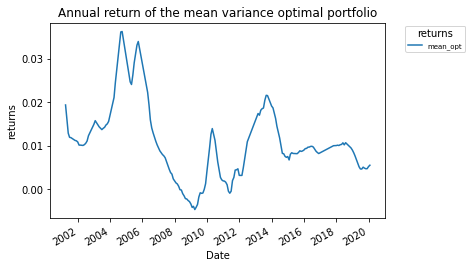

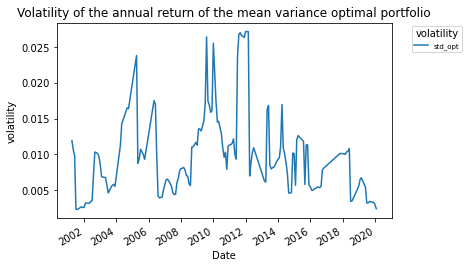

In [26]:
# Plot the mean of the equally weighted portfolio
mean_port_opt = pd.concat([pd.DataFrame({"date":set_date_opt}),pd.DataFrame({"mean_opt":set_mu_opt})],axis=1)
mean_port_opt.date = pd.to_datetime(mean_port_opt["date"])
mean_port_opt.set_index("date", inplace=True)
mean_port_opt.plot()

plt.title("Annual return of the mean variance optimal portfolio")
plt.legend(title='returns', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("returns")



# Plot the stdev of the annual return of the equally weighted portfolio
std_port_opt = pd.concat([pd.DataFrame({"date":set_date_opt}), pd.DataFrame({"std_opt":set_sig_opt})],axis=1)
std_port_opt.date = pd.to_datetime(std_port_opt["date"])
std_port_opt.set_index("date", inplace=True)
std_port_opt.plot()

plt.title("Volatility of the annual return of the mean variance optimal portfolio")
plt.legend(title='volatility', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("volatility")
    


<a id='compareportfolios'></a>
# Compare different investing strategies
* Return and volatility
* Risk measures
    - Sharpe ratio

### Compare the returns and volatilities of two portfolio making strategy

Text(0, 0.5, 'volatility')

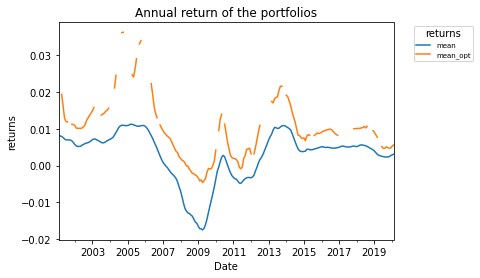

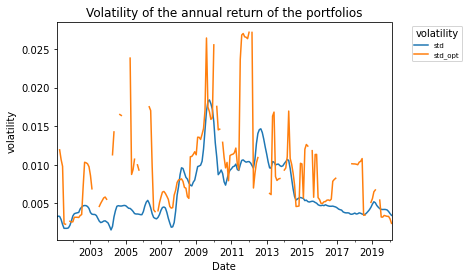

In [27]:
# The returns
mean_port_together= pd.concat([mean_port, mean_port_opt["mean_opt"]], axis=1)
mean_port_together.plot()


plt.title("Annual return of the portfolios")
plt.legend(title='returns', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("returns")


# The stds
std_port_together= pd.concat([std_port, std_port_opt["std_opt"]], axis=1)
std_port_together.plot()

plt.title("Volatility of the annual return of the portfolios")
plt.legend(title='volatility', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("volatility")
    

<a id='sharpe'></a>    

### Sharpe ratio

* In order to take into consideration the means and stds at the same time, we look into the sharpe ratio of two portfolio making strategies.

Text(0, 0.5, 'Sharpe ratio')

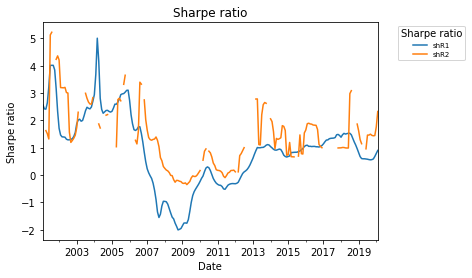

In [28]:
# Drwo shapre ratios of two portfolios 
port_together= pd.concat([mean_port, mean_port_opt["mean_opt"], std_port, std_port_opt["std_opt"]], axis=1)
port_together["shR1"] = port_together["mean"]/port_together["std"]
port_together["shR2"] = port_together["mean_opt"]/port_together["std_opt"]

port_together2 = port_together[["shR1","shR2"]]
port_together2.set_index=port_together.index
port_together2.plot()


plt.title("Sharpe ratio")
plt.legend(title='Sharpe ratio', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.xlabel("Date")
plt.ylabel("Sharpe ratio")


### Indicator 

* We can generate a graph that indicates when the optimally weighted portfolios gave us higher Sharpe ratio than the equally weighted portfolios over the last periods. 

Text(0, 0.5, 'Indicator')

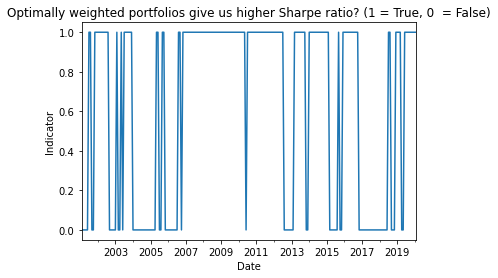

In [29]:
port_together2.fillna(0, inplace= True)
port_together2.head()
is_optport_better_than_eqport = port_together2["shR1"] < port_together2["shR2"]
is_optport_better_than_eqport.replace(False, 0, inplace= True)
is_optport_better_than_eqport.replace(True, 1, inplace= True)
is_optport_better_than_eqport.plot()

plt.title("Optimally weighted portfolios give us higher Sharpe ratio? (1 = True, 0  = False)")
plt.xlabel("Date")
plt.ylabel("Indicator")


<a id='conclusion'></a>
# Conclusion

* We found that the equally weighted portfolio performed as well as the optimally weighted portfolio in terms of Sharpe ratio before the subprime mortgage crisis.
* However, we can see that the optimally weighted portfolio perform better since the 2008 financial crisis for most of periods. 